# Séance 1 - Réseau dense : Proposition de correction

Ce notebook est une proposition de correction pour le TP de la séance 1. Un travail différent peut être correct sans pour autant être identique à celui-là.

Commençons par importer l'ensemble des éléments dont nous aurons besoin.


In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = (mnist.load_data())
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.8)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

## Sujet B - Il y a des hasards meilleurs que d'autres

L'objectif est de comparer plusieurs réseaux de neurones selon différentes distributions initiales des poids. Nous considérerons trois initialisations :

* **Random uniform** : Distribution uniforme entre [-0.05, 0.05[ par défaut
* **Glorot uniform** : Distribution Glorot version uniforme
* **He uniform** :Distribution He version uniforme

Egalement nous considérerons deux fonctions d'activation : **ReLU** et **sigmoid**. Pour être le plus efficace possible, nous allons définir une fonction qui prendra en paramètres la fonction d'activation et la distribution initiale des poids. Egalement le learning rate et le nombre d'époques d'entraînement. Cette fonction renverra l'historique d'entraînement pour que l'on puisse en tracer les courbes d'apprentissage.

Puisqu'on sait que les différences sont censées impacter les réseaux *profonds*, nous allons construire un réseau de neurones avec 4 couches cachées (peu profond) pour voir si l'on observe ou non le phénomène de disparition des gradients.

In [ ]:
def design_and_train(learning_rate, n_epochs, activation, initializer, verbose=1):
  model = keras.models.Sequential([
      keras.layers.Flatten(input_shape=[28, 28]),
      keras.layers.Dense(128, activation=activation, kernel_initializer=initializer),
      keras.layers.Dense(64, activation=activation, kernel_initializer=initializer),
      keras.layers.Dense(32, activation=activation, kernel_initializer=initializer),
      keras.layers.Dense(16, activation=activation, kernel_initializer=initializer),
      keras.layers.Dense(10, activation="softmax", kernel_initializer=initializer)
    ])
  model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=learning_rate), metrics=["accuracy"])
  history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_valid, y_valid), verbose=verbose)
  return history

D'après la théorie, on s'attend à:
* Bon apprentissage pour le couple (Sigmoid - Glorot)
* Bon apprentissage pour le couple (ReLU - He)

Il est probable que le couple (Relu - Glorot) fonctionne également, mais moins bien que le couple avec la distribution initiale He. Réciproquement pour le couple (Sigmoid - He).
Concernant l'initialisation aléatoire, on s'attend à ce que le réseau n'apprenne pas pour la fonction d'activation sigmoid, mais il est possible que le réseau apprenne pour la fonction d'activation ReLU sans être efficace.

In [ ]:
n_epochs = 75
learning_rate = 1e-3

results = []
for activation in ["relu", "sigmoid"]:
  for initializer in ["random_uniform", "glorot_uniform", "he_uniform"]:
    print("Activation: %s - Initalizer: %s" % (activation, initializer))
    history = design_and_train(learning_rate=learning_rate, n_epochs=n_epochs, activation=activation, initializer=initializer, verbose=0)
    result = {"activation": activation, "initializer": initializer, "history": pd.DataFrame(history.history)}
    results.append(result)

Activation: relu - Initalizer: random_uniform
Activation: relu - Initalizer: glorot_uniform
Activation: relu - Initalizer: he_uniform
Activation: sigmoid - Initalizer: random_uniform
Activation: sigmoid - Initalizer: glorot_uniform
Activation: sigmoid - Initalizer: he_uniform


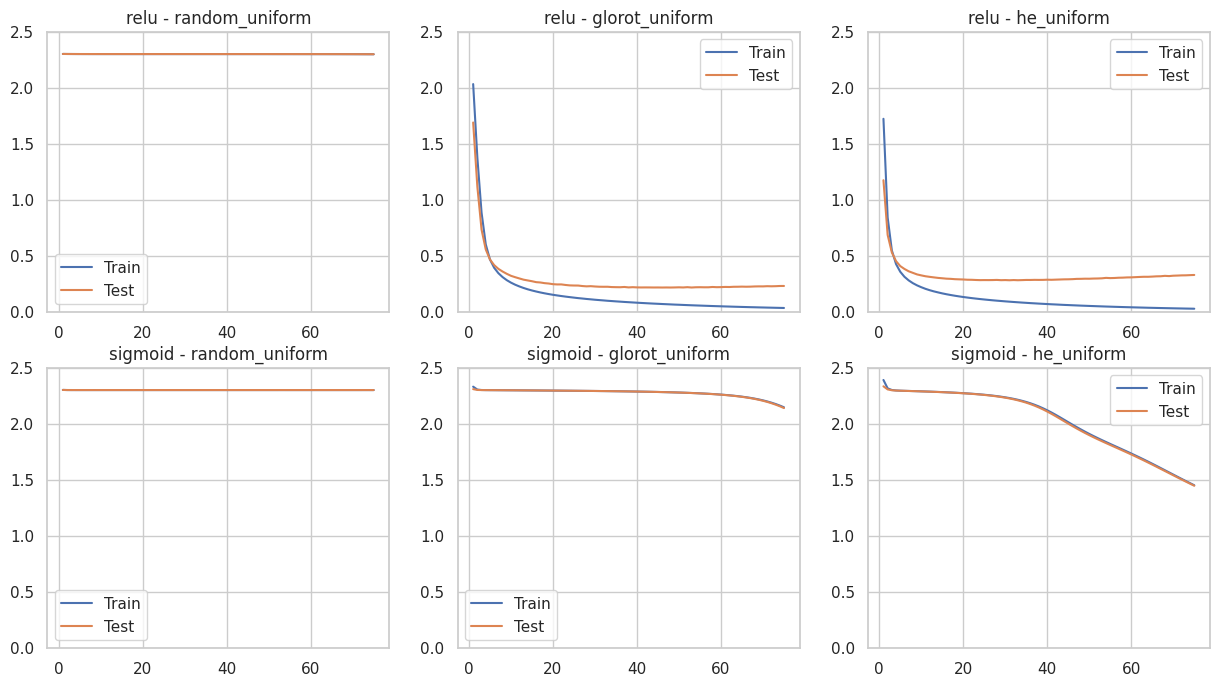

In [ ]:
plt.figure(figsize=(15, 8))
epochs = range(1, n_epochs+1)
for index, result in enumerate(results):
  plt.subplot(2, 3, index+1)
  historic = result["history"]
  plt.plot(epochs, historic["loss"], label="Train")
  plt.plot(epochs, historic["val_loss"], label="Test")
  plt.ylim(0, 2.5)
  title = "%s - %s" % (result["activation"], result["initializer"])
  plt.title(title)
  plt.legend()

plt.show()

* L'initialisation random des poids n'a jamais réussi à converger
* Les couples (ReLU - Glorot) et (ReLU - He) ont le mieux appris, avec (ReLU - Glorot) qui semble meilleur sur cet exemple
* La fonction sigmoid n'a jamais vraiment réussi à être performante : le réseau était trop profond pour permettre un bon entraînement

Cette comparaison n'est pas parfaite pour plusieurs raisons, mais on peut notamment citer qu'on ne l'a fait qu'une seule fois alors qu'il faudrait le réaliser plusieurs fois pour tenir compte de l'aléatoire de l'initialisation. De plus, le résultat n'est valable que pour ce dataset avec cette architecture-là.